In [68]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from read_svm import CustomTensorDataset
from read_svm import CustomImageFolder
import joblib

In [69]:
# parameter

np.random.seed(121)


In [70]:
gan = True
if gan:
  file_path = './split_data_gan.pkl'
else:
  file_path = './split_data_wo_gan.pkl'
X_train, X_test, y_train, y_test = joblib.load(file_path)

In [71]:
Dataset_tr = CustomTensorDataset(X_train, y_train)
Dataset_te = CustomTensorDataset(X_test, y_test)

print(len(Dataset_tr), len(Dataset_te))
print(Dataset_tr[0])

2993 657
(tensor([[[100., 100., 100.,  ..., 105., 102.,  97.],
         [101.,  99.,  98.,  ..., 104., 105., 107.],
         [104., 102.,  99.,  ...,  98., 100., 102.],
         ...,
         [114., 118., 120.,  ..., 108., 113., 116.],
         [110., 115., 118.,  ..., 107., 113., 115.],
         [106., 111., 116.,  ..., 106., 111., 114.]]]), tensor(0))


In [72]:
"""train_1_dir = "../train_1"
test_1_dir = "../test_1"
train_0_dir = "../train_0"
test_0_dir = "../test_0"

# Load the images and data loader for training and testing
Dataset_tr = CustomImageFolder(train_1_dir, train_0_dir, transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
]))
Dataset_te = CustomImageFolder(test_1_dir, test_0_dir, transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
]))
print(len(Dataset_tr), len(Dataset_te))
print(Dataset_tr[0])"""

'train_1_dir = "../train_1"\ntest_1_dir = "../test_1"\ntrain_0_dir = "../train_0"\ntest_0_dir = "../test_0"\n\n# Load the images and data loader for training and testing\nDataset_tr = CustomImageFolder(train_1_dir, train_0_dir, transform = transforms.Compose([\n    transforms.Resize((64, 64)),\n    transforms.ToTensor()\n]))\nDataset_te = CustomImageFolder(test_1_dir, test_0_dir, transform = transforms.Compose([\n    transforms.Resize((64, 64)),\n    transforms.ToTensor()\n]))\nprint(len(Dataset_tr), len(Dataset_te))\nprint(Dataset_tr[0])'

In [73]:
#extract the features for svm
def extract_features(dataloader, model):
    features = []
    labels = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.view(-1, 1, 128, 128).to(device)
            targets = targets.to(device)

            # Forward pass through the model
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

# Train an SVM classifier
def train_svm(train_features, train_labels, test_features, test_labels):
    # Initialize the SVM model
    svm_model = SVC(kernel='rbf', class_weight = 'balanced',random_state=42)

    print("Training SVM...")
    svm_model.fit(train_features, train_labels)

    predictions = svm_model.predict(test_features)

    # Evaluate the model
    print("Classification Report:")
    print(classification_report(test_labels, predictions))
    accuracy = accuracy_score(test_labels, predictions)
    weighted_f1 = f1_score(test_labels, predictions, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"The weighted F1 score :{weighted_f1:.4f}")


    return svm_model

In [74]:
#RESNET18 test. not satisfied. can't use advanced models. lead to worse results.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) #change the first layer channel from 3 to 1 for grayscale

feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the final classification layer
feature_extractor = feature_extractor.to(device)

trainloader = torch.utils.data.DataLoader(Dataset_tr, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(Dataset_te, batch_size=32, shuffle=False)

train_features, train_labels = extract_features(trainloader, feature_extractor)
test_features, test_labels = extract_features(testloader, feature_extractor)
#Flatten to 1d
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Train the SVM
svm_model = train_svm(train_features, train_labels, test_features, test_labels)

C:\Users\Administratior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administratior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training SVM...
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       551
           1       0.50      0.18      0.26       106

    accuracy                           0.84       657
   macro avg       0.68      0.57      0.59       657
weighted avg       0.80      0.84      0.81       657

Accuracy: 0.8387
The weighted F1 score :0.8053


In [75]:
#Try PCA as a dedimensionalizer.
def pca(train_features,test_features,n_components):
  pca = PCA(n_components=n_components)
  train_features_pca = pca.fit_transform(train_features)
  test_features_pca = pca.transform(test_features)
  explained_variance = np.sum(pca.explained_variance_ratio_)
  print(f"Explained variance by {n_components} components: {explained_variance:.2f}")
  return train_features_pca, test_features_pca

In [76]:
n_components = 50
train_features_pca, test_features_pca = pca(train_features, test_features, n_components)

svm_model_pca = train_svm(train_features_pca, train_labels, test_features_pca, test_labels)

#improved but not a lot

Explained variance by 50 components: 1.00
Training SVM...
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       551
           1       0.53      0.29      0.38       106

    accuracy                           0.84       657
   macro avg       0.70      0.62      0.64       657
weighted avg       0.82      0.84      0.83       657

Accuracy: 0.8447
The weighted F1 score :0.8253


In [77]:
# try grid seach
def grid_search_svm(train_features_pca, train_labels, test_features_pca, test_labels):
    print("Starting GridSearchCV for SVM...")
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)
    grid.fit(train_features_pca, train_labels)

    print("Best parameters found:", grid.best_params_)


    best_model = grid.best_estimator_
    predictions = best_model.predict(test_features_pca)

    print("Classification Report:")
    print(classification_report(test_labels, predictions))
    accuracy = accuracy_score(test_labels, predictions)
    weighted_f1 = f1_score(test_labels, predictions, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"The weighted F1 score :{weighted_f1:.4f}")

    return best_model

Starting GridSearchCV for SVM...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......

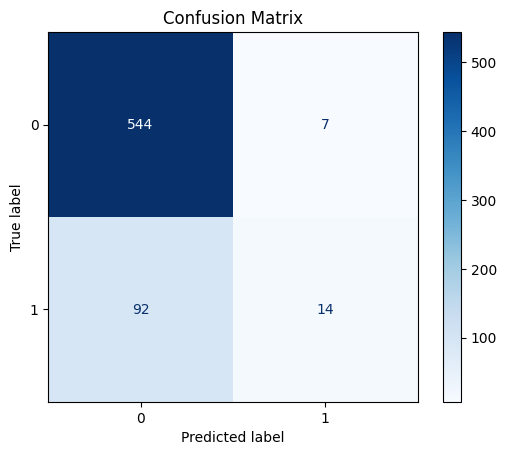

In [78]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}
best_svm_model = grid_search_svm(train_features_pca, train_labels, test_features_pca, test_labels)

#Confusion matrix
prediction = best_svm_model.predict(test_features_pca)
cm = confusion_matrix(test_labels, prediction)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#not much change. svm has reached its limit.

In [79]:
gan = False
if gan:
  file_path = './split_data_gan.pkl'
else:
  file_path = './split_data_wo_gan.pkl'
X_train, X_test, y_train, y_test = joblib.load(file_path)

Dataset_tr = CustomTensorDataset(X_train, y_train)
Dataset_te = CustomTensorDataset(X_test, y_test)

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) #change the first layer channel from 3 to 1 for grayscale

feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])  # Remove the final classification layer
feature_extractor = feature_extractor.to(device)

trainloader = torch.utils.data.DataLoader(Dataset_tr, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(Dataset_te, batch_size=32, shuffle=False)

train_features, train_labels = extract_features(trainloader, feature_extractor)
test_features, test_labels = extract_features(testloader, feature_extractor)
#Flatten to 1d
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Train the SVM
svm_model = train_svm(train_features, train_labels, test_features, test_labels)

C:\Users\Administratior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administratior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training SVM...
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       551
           1       0.41      0.56      0.47       106

    accuracy                           0.80       657
   macro avg       0.66      0.70      0.67       657
weighted avg       0.83      0.80      0.81       657

Accuracy: 0.7976
The weighted F1 score :0.8096


In [81]:
n_components = 50
train_features_pca, test_features_pca = pca(train_features, test_features, n_components)

svm_model_pca = train_svm(train_features_pca, train_labels, test_features_pca, test_labels)

Explained variance by 50 components: 1.00
Training SVM...
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       551
           1       0.41      0.59      0.48       106

    accuracy                           0.79       657
   macro avg       0.66      0.71      0.68       657
weighted avg       0.83      0.79      0.81       657

Accuracy: 0.7945
The weighted F1 score :0.8090


Starting GridSearchCV for SVM...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......

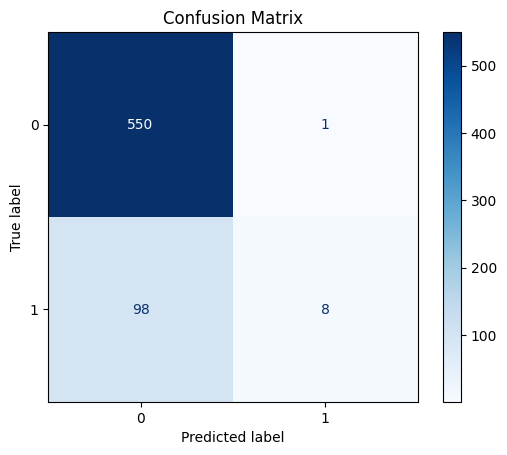

In [82]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}
best_svm_model = grid_search_svm(train_features_pca, train_labels, test_features_pca, test_labels)

prediction = best_svm_model.predict(test_features_pca)
cm = confusion_matrix(test_labels, prediction)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()